In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs
!pip install kneed

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, visual, medical

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.settings.enforce_versions=True
nlp.install(refresh_install=True, visual=True)

In [4]:
# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_8542 (4).json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==5.3.1, 💊Spark-Healthcare==5.3.1, 🕶Spark-OCR==5.3.1, running on ⚡ PySpark==3.4.0


## Define pipeline for compute features

In [5]:
import pyspark
import json
import os
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *
from pyspark.ml import PipelineModel, Pipeline
from pyspark.ml.feature import PCA, StandardScaler
from pyspark.ml.clustering import KMeans
from kneed import KneeLocator

In [6]:
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image")

embeddings = VitImageEmbeddings \
    .pretrained("vit_image_embeddings", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("embeddings")

scaler = StandardScaler() \
    .setInputCol("embeddings") \
    .setOutputCol("scaled_embeddings")

pca = PCA() \
    .setInputCol("scaled_embeddings") \
    .setOutputCol("pcaFeatures") \
    .setK(100)

pipeline = Pipeline(stages=[
     binary_to_image,
     embeddings,
     scaler,
     pca
])

vit_image_embeddings download started this may take some time.
Approximate size to download 303.6 MB


## Read images to the datafram and display it

In [ ]:
!gdown 1lBkiTKuQha43UCJJ0Qk79gcCqzZXMnNt
#!wget https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/visual-nlp/data/images_clustering.zip
!unzip images_clustering.zip


    Image #0:
    Origin: file:/content/images_clustering/document_with_signature1.png
    Resolution: 0 dpi
    Width: 2549 px
    Height: 3506 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


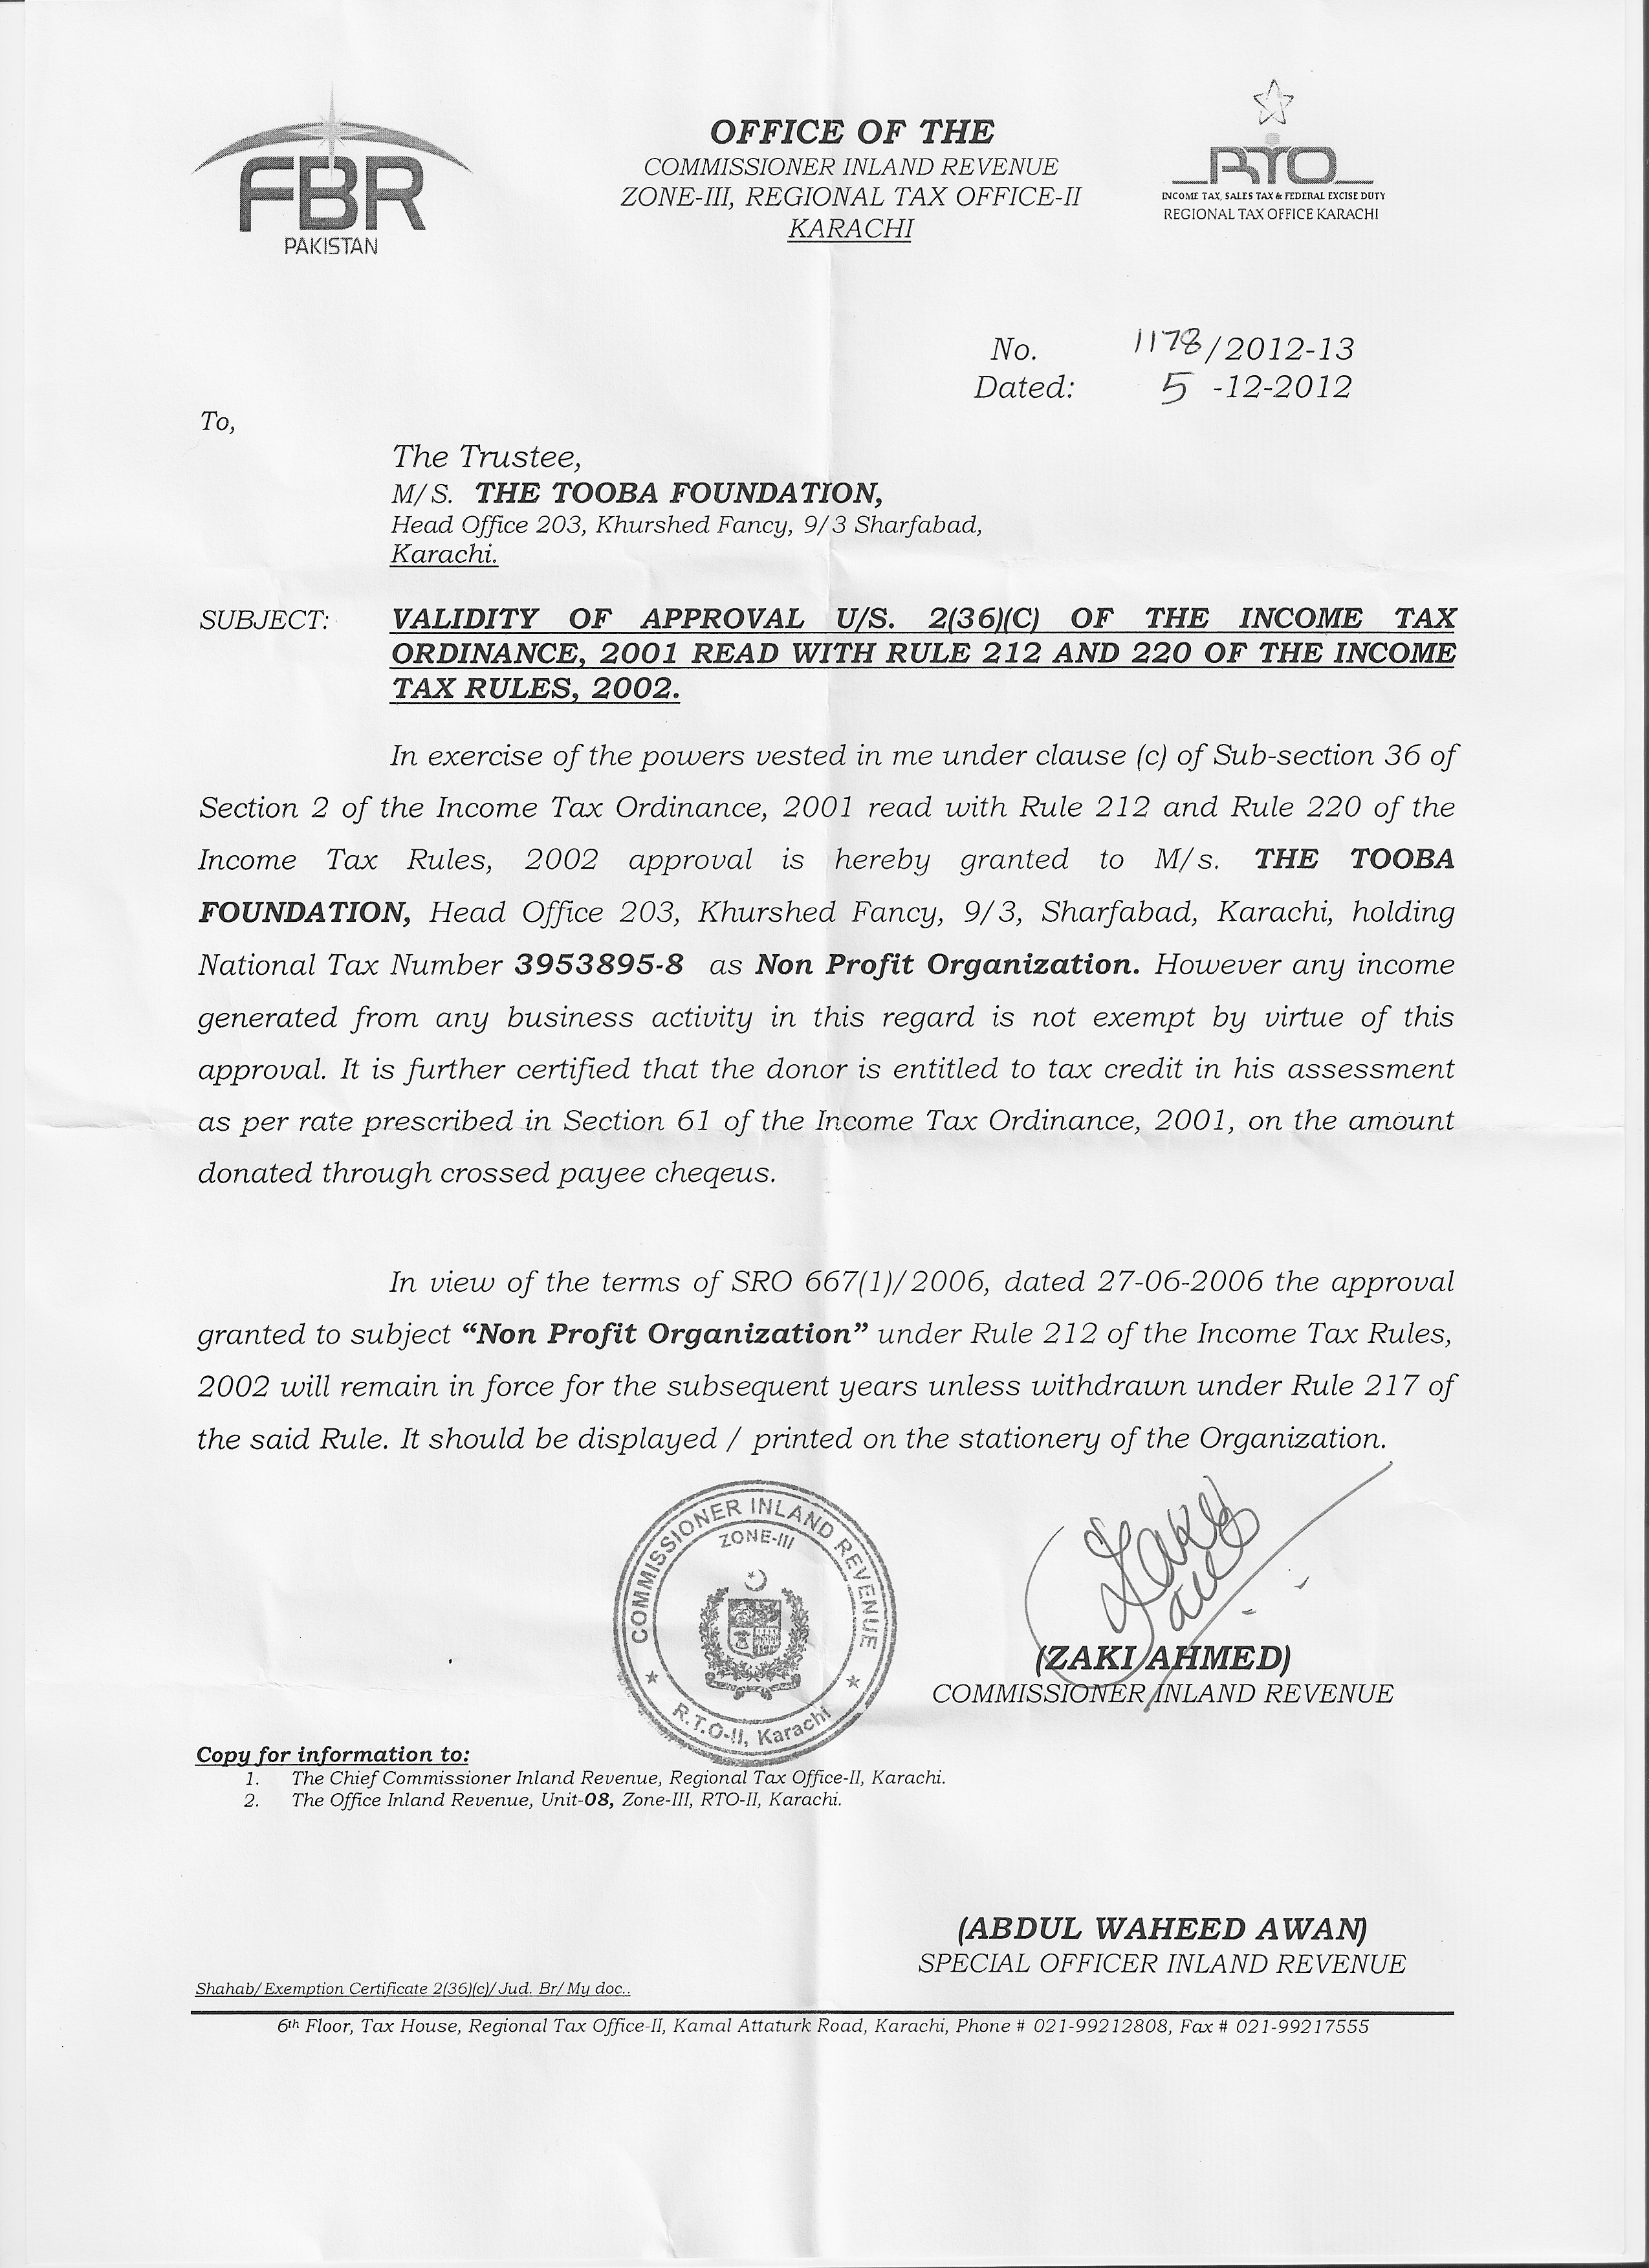


    Image #1:
    Origin: file:/content/images_clustering/adv3.jpeg
    Resolution: 72 dpi
    Width: 1600 px
    Height: 2100 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


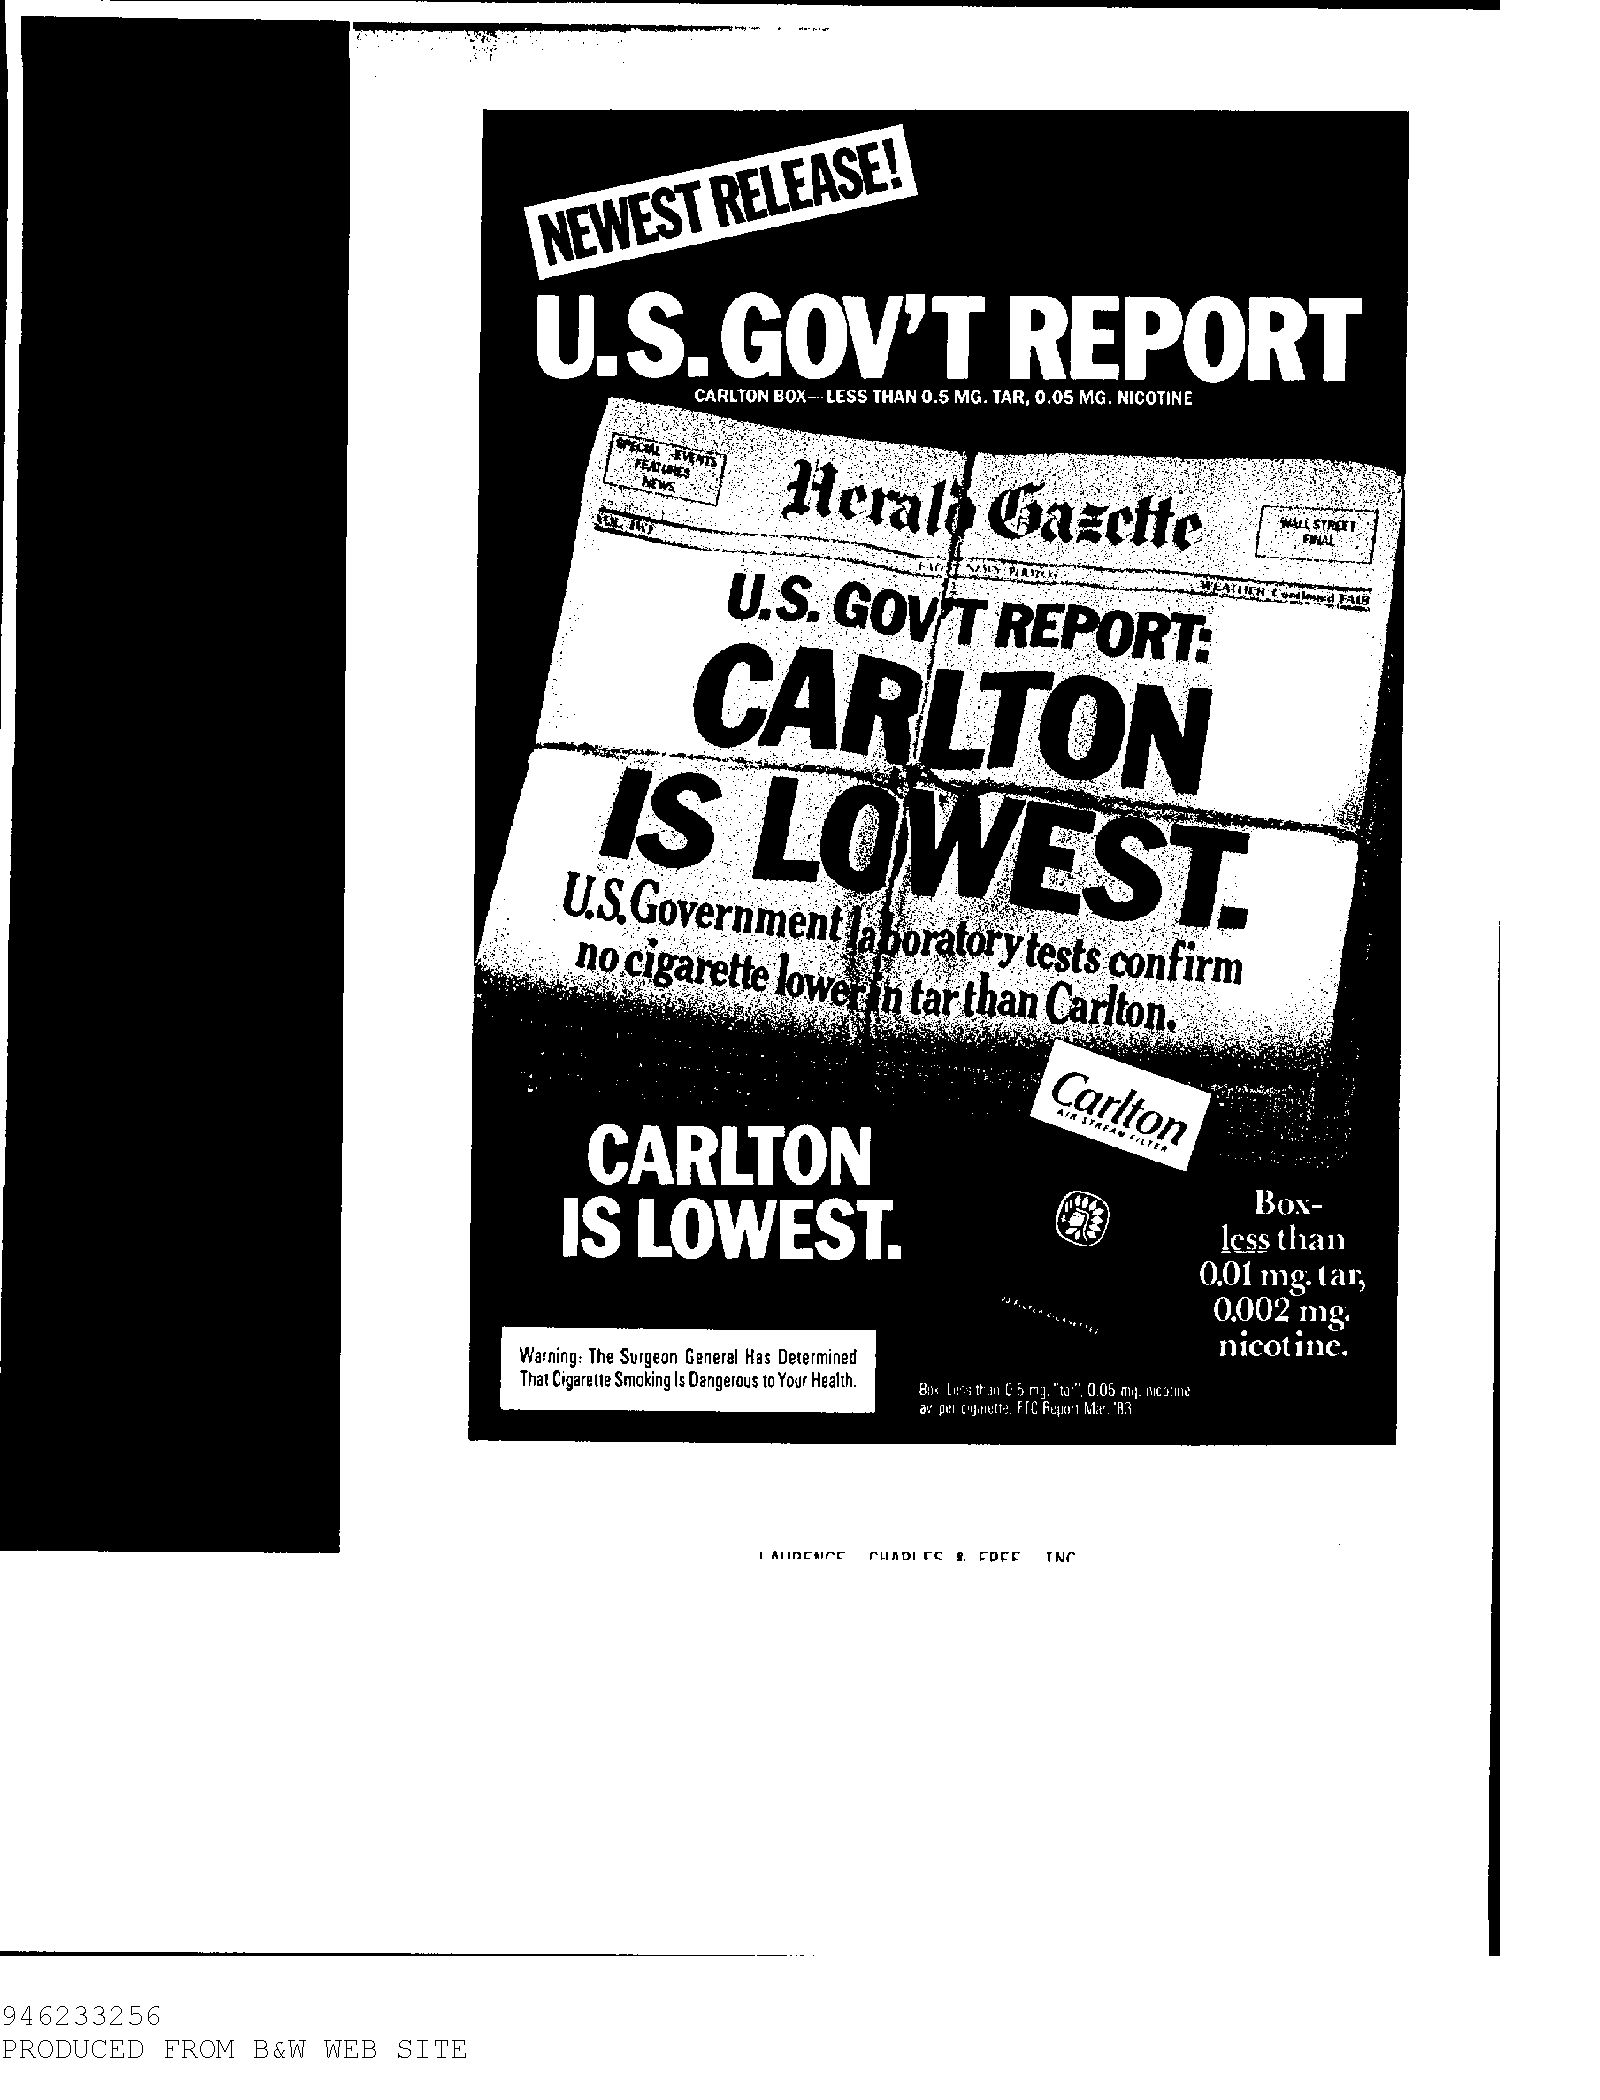


    Image #2:
    Origin: file:/content/images_clustering/dicom1.jpeg
    Resolution: 96 dpi
    Width: 914 px
    Height: 985 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


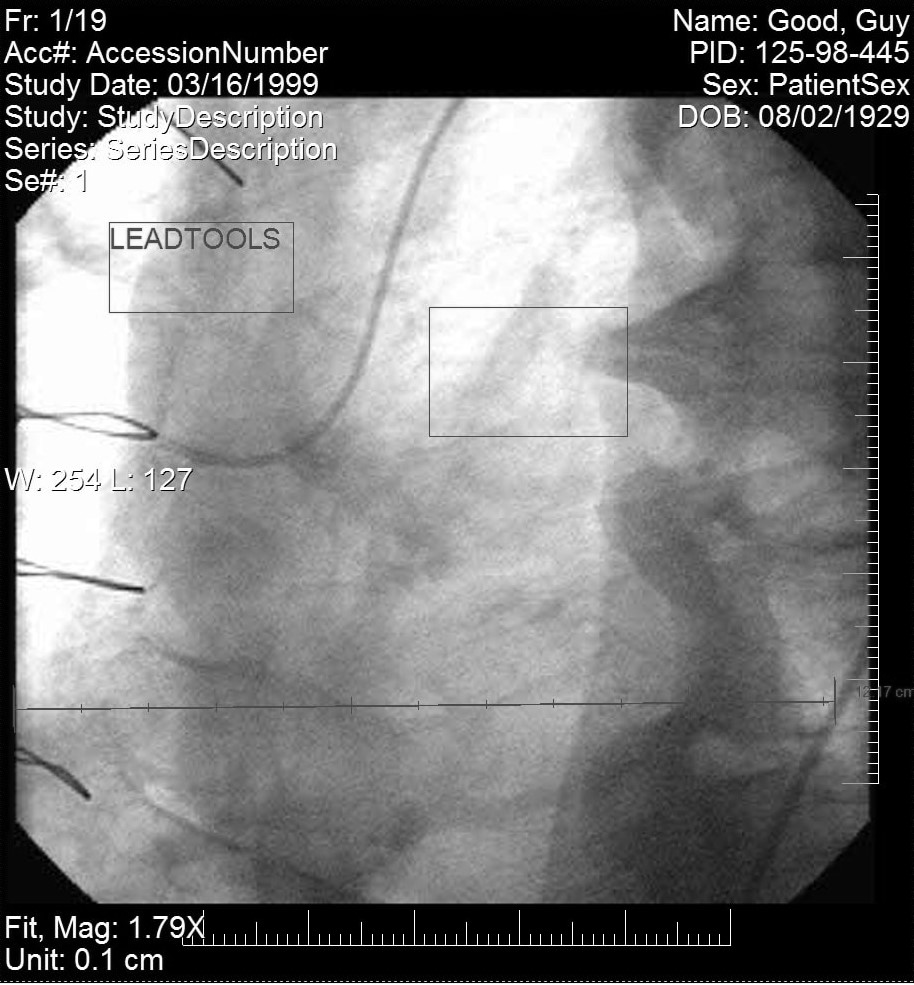


    Image #3:
    Origin: file:/content/images_clustering/adv1.jpeg
    Resolution: 72 dpi
    Width: 1200 px
    Height: 1575 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


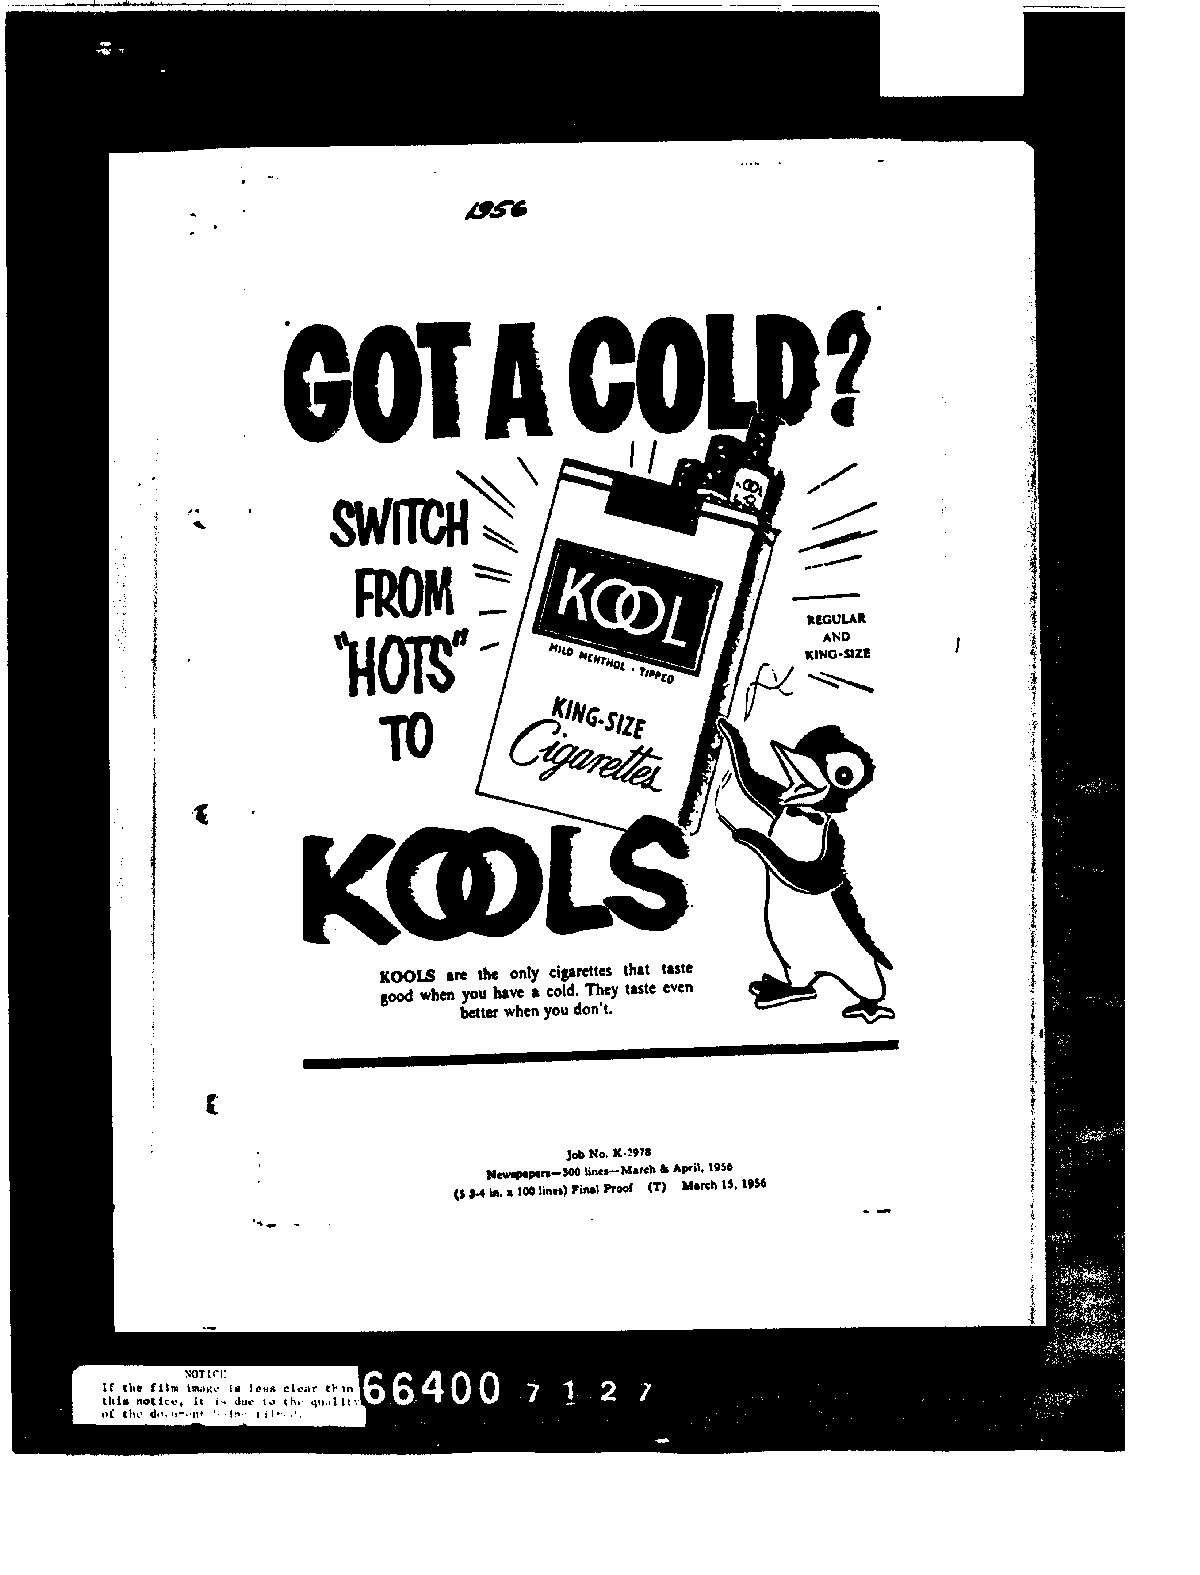


    Image #4:
    Origin: file:/content/images_clustering/table3.png
    Resolution: 72 dpi
    Width: 628 px
    Height: 335 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


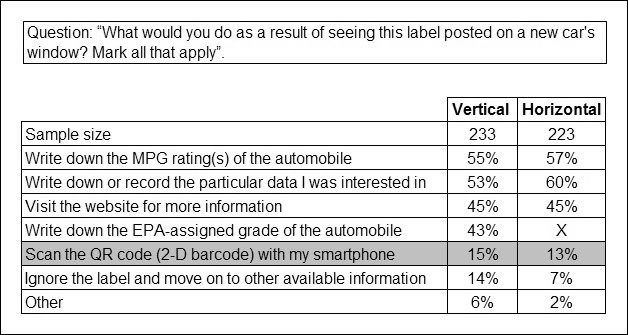

In [8]:
import pkg_resources
examples = "/content/images_clustering/"
df = spark.read.format("binaryFile").load(examples).cache()
display_images(BinaryToImage().transform(df))

## Call pipeline for compute features

In [9]:
features = pipeline.fit(df).transform(df).cache()

## Elbow method to find the optimal  k

We will be using a knee point detection algorithm in order to automatically find the "elbow" which likely corresponds to the optimal value of k.

In [ ]:
k_max = 10
ks_to_test = range(2, k_max)

distortions = []

for k in ks_to_test:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('pcaFeatures')
    model = kmeans.fit(features)
    distortions.append(model.summary.trainingCost)


kneedle = KneeLocator(ks_to_test, distortions, curve="convex", direction="decreasing")

kneedle.plot_knee(figsize=(6,6))

k = kneedle.elbow

# Training a final model with the ideal  k

In [11]:
kmeans = KMeans(featuresCol='pcaFeatures', k=k)
model = kmeans.fit(features)

predicitions = model.transform(features)

In [12]:
predicitions.select("path", "prediction").show(truncate=False)

+------------------------------------------------------------+----------+
|path                                                        |prediction|
+------------------------------------------------------------+----------+
|file:/content/images_clustering/document_with_signature1.png|4         |
|file:/content/images_clustering/adv3.jpeg                   |1         |
|file:/content/images_clustering/dicom1.jpeg                 |3         |
|file:/content/images_clustering/adv1.jpeg                   |1         |
|file:/content/images_clustering/table3.png                  |0         |
|file:/content/images_clustering/email2.jpeg                 |2         |
|file:/content/images_clustering/dicom2.jpeg                 |3         |
|file:/content/images_clustering/email1.jpeg                 |2         |
|file:/content/images_clustering/table1.png                  |0         |
|file:/content/images_clustering/document_with_signature2.png|4         |
+-------------------------------------

In [13]:
predicitions.groupBy("prediction").count().orderBy("prediction").toPandas()

prediction  count
0           0      2
1           1      2
2           2      2
3           3      2
4           4      2